In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
from pyts.image import GramianAngularField

In [2]:
## load data
tickers = ['RELIANCE.NS']
start, end = '2016-01-01', '2021-12-31'
stock_data = yf.download(tickers = tickers, 
                 start = start, 
                 end = end, 
                 progress=True, 
                 interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
def make_label(typical_prices, next_close_price, n = 1.5):
    # bollenger band
    mean_price = np.mean(typical_prices)
    std_dev = np.std(typical_prices)
    if next_close_price >= mean_price + std_dev * n:
        label = 1               # price appricated      (Sell signal)
    elif next_close_price <= mean_price - std_dev * n:
        label = 2               # price depreciated     (Buy opportunity)
    else:
        label = 3               # price indifferent      (indifferent to make decision)
    return label

In [6]:
ohlc_columns = ['Open', 'High', 'Low', 'Close']
w = 28          # window size
data = []
gasf = GramianAngularField(image_size=w, method = 'summation')
for i in range(len(stock_data)-w - 1, -1, -1):
    gasf_images = [gasf.transform([stock_data[c][i:i+w]]) for c in ohlc_columns]
    typical_prices = (stock_data['High'][i:i+w] + stock_data['Low'][i:i+w] + stock_data['Close'][i:i+w]) /3 
    label = make_label(typical_prices = typical_prices, 
                       next_close_price = stock_data['Close'][i+w])
    combined_gasf_image = np.array(gasf_images)#/len(gasf_images)
    data.append((i, combined_gasf_image, label))
    break

In [17]:
np.vstack(gasf_images).shape

(4, 28, 28)

In [16]:
np.array(gasf_images).shape

(4, 1, 28, 28)

In [57]:
from collections import Counter
labels = [d[-1] for d in data]
Counter(labels)

Counter({3: 912, 1: 332, 2: 209})

In [65]:
import pickle
with open('../data/test_HDFCBANK.NS.pkl', 'rb') as f:
    data = pickle.load(f)

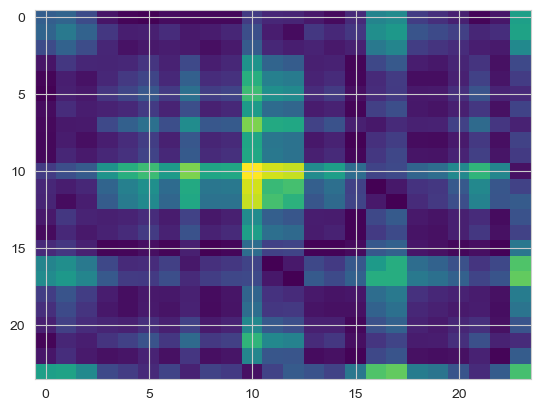

In [82]:
plt.imshow(data[120][1][-1], cmap='viridis', aspect='auto')
#plt.axis('off')
plt.show()

In [87]:
data[120][1][-1][0, :]

array([-0.4899018 , -0.45438421, -0.6123602 , -0.89813367, -0.96892478,
       -0.98119678, -0.93479429, -0.94746058, -0.95849324, -0.95871371,
       -0.70205082, -0.8082009 , -0.82080449, -0.87771289, -0.94480858,
       -0.79081404, -0.24050539, -0.18422287, -0.69059254, -0.76353561,
       -0.84832492, -0.97081357, -0.88973966, -0.05084613])

RL data arrangement

In [11]:
import pandas as pd
import numpy as np
import pickle

In [12]:
kind = 'train'
tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFC.NS', 'INFY.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'HDFCBANK.NS', 
           'BHARTIARTL.NS', 'KOTAKBANK.NS', 'WIPRO.NS', 'LT.NS']

# load
data = {}
for tick in tickers:
    with open(f'../data/{kind}_{tick}.pkl', 'rb') as f:
        data[tick] = pickle.load(f)[::-1]

In [30]:
## lets put together prices first
prices = {}
labels = {}
for tick in tickers:
    prices[tick] = [item[3] for item in data[tick]]
    labels[tick] = [item[2] for item in data[tick]]

In [32]:
df_prices = pd.DataFrame.from_dict(prices)
df_labels = pd.DataFrame.from_dict(labels)

In [43]:
images = []
labels = []
for idx in range(len(df_labels)):
    batch_images = [data[tick][idx][1] for tick in tickers if data[tick][idx][0] == idx]
    batch_labels = [data[tick][idx][2] for tick in tickers if data[tick][idx][0] == idx]
    images.append(batch_images)
    labels.append(batch_labels)
        

In [44]:
for i in images:
    assert len(i) == len(tickers)

In [47]:
np.array(images[-1]).shape, np.array(labels[-1]).shape

((11, 1, 24, 24), (11,))